#  Capstone Project 2: Stock price forecasting
# Section 4: Feature Engineering

In this notebook we will focus on the feature engineering part of our project. We will compute financial indicators based on stock prices and earnings per share that will be considered as new features and added to our dataframe. Subsequently, we will perform a rescaling of the numerical values in our dataframe and separate it into a train and test set. It is important to notice that we are dealing with a time series, so the usual random splitting into train and test sets is not suitable here.

## Financial indicators as features

We are going to introduce a series of financial indicators that are typically used in finance and add them to our dataframe as new features. As we will need to compute them for two stocks, it is useful to define functions that perform the computation in order to avoid repeating our code. We will introduce them one by one along with the corresponding code.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In finance, a momentum oscillator is an indicator that issues a signal when a price move or trend is about to start. It can fluctuate between an upper and lower band or across a zero line, highlighting relative strength or weakness within a specific time frame. Momentum oscillators are used to identify potential overbought or oversold conditions in a market, oscillating between 0 and 100. They can provide signals that suggest when an asset's price is deviating from its underlying trend, which may suggest a price correction or reversal. We will be dealing with different types of oscillators in the following.

### Relative Strength Index (RSI)

Relative Strength Index is a momentum oscillator that measures the speed and change of price movements. It is primarily used to identify overbought or oversold conditions in a trading instrument.

The RSI calculation is based on 14 periods, which can be intraday, daily, weekly, or monthly price data. The result is represented as a value between 0 and 100. An RSI of 70 or above typically indicates that a stock is overbought, and could be primed for a trend reversal or corrective pullback in price. An RSI of 30 or below indicates that a stock may be oversold, and could also be primed for a trend reversal or corrective price bounce. An RSI of 50 is considered neutral.

For its computation, one first computes the average gain and average loss. For a given timeframe (typically 14 periods), we compute the average of price gains and losses during upward and downward movements respectively. Then one calculates the Relative Strength (RS), the average gain divided by the average loss. The RSI is defined as RSI = 100 - (100 / (1 + RS)).

In [2]:
# Create a function that computes the RSI and adds it to our dataframe

def rsi(data, period=14):
    '''
    Calculate the Relative Strength Index (RSI) of a given pandas DataFrame.

    Parameters:
    data: DataFrame, the input pandas DataFrame.
    period: int, the period over which to calculate the RSI. Default is 14.

    Returns:
    data: DataFrame, the DataFrame with the added RSI column.
    '''
    
    # Ensure data is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Data should be a pandas DataFrame.")
        
    # Calculate the daily price changes
    data['Price Change'] = data['Close'].diff()

    # Split price changes into positive and negative lists
    positive_changes = data['Price Change'].apply(lambda x: x if x > 0 else 0)
    negative_changes = data['Price Change'].apply(lambda x: abs(x) if x < 0 else 0)

    # Calculate the average gains and losses over the period
    average_gain = positive_changes.rolling(window=period, min_periods=1).mean()
    average_loss = negative_changes.rolling(window=period, min_periods=1).mean()

    # Calculate the relative strength (RS)
    relative_strength = average_gain / average_loss

    # Calculate the RSI and add it as a new column in the dataframe
    data['RSI'] = 100 - (100 / (1 + relative_strength))
    
    return data


### K value

The Stochastic Oscillator is a momentum indicator that compares a particular closing price of a stock to a range of its prices over a certain period of time. The formula to calculate the Stochastic Oscillator is:

K = 100(C - L14)/(H14 - L14)

where C is the most recent closing price, L14 is the lowest price traded of the 14 previous trading sessions and H14 is the highest price traded during the same 14-day period.

The Stochastic Oscillator generates values between 0 and 100. A reading above 80 is typically considered as overbought territory, which could indicate that a price pullback is likely. On the other hand, a reading below 20 is considered as oversold territory, which could indicate that a price bounce is coming.


In [3]:
# Create a function that computes the K and R values and adds them to our dataframe

def k(data, period=14):
    '''
    Calculate the K value of a given pandas DataFrame.

    Parameters:
    data: DataFrame, the input pandas DataFrame.
    period: int, the period over which to calculate the values. Default is 14.

    Returns:
    data: DataFrame, the DataFrame with added K column.
    '''
    
    # Ensure data is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Data should be a pandas DataFrame.")
        
    # Calculate highest high and lowest low over the period
    data['Highest High'] = data['High'].rolling(window=period).max()
    data['Lowest Low'] = data['Low'].rolling(window=period).min()

    # Calculate K value
    data['K'] = ((data['Close'] - data['Lowest Low']) / (data['Highest High'] - data['Lowest Low'])) * 100
    
    data.drop(['Highest High', 'Lowest Low'], axis=1, inplace=True)


    return data


### Moving Average Convergence Divergence (MACD)

A moving average (MA) is a tool in technical analysis that helps smooth out price data by creating a constantly updated average price. The average is taken over a specific period of time, which is the trader's choice.

In technical analysis, the moving average can serve multiple purposes:

1) It can act as a simple trading signal when prices cross the moving average.

2) It can show a stock's price trend over a given period.

3) It can indicate a potential trend reversal when the moving average line itself changes direction.


The Exponential Moving Average (EMA) is a type of moving average that places a greater weight and significance on the most recent data points.  The EMA is often used in time series analysis to smooth out short-term fluctuations and highlight longer-term trends or cycles. It is especially useful in volatile markets where price can fluctuate a lot, as it helps filter out the 'noise'.

The formula for EMA is:

EMA = (Closing price - EMA(previous day)) x multiplier + EMA(previous day)

The multiplier is calculated as follows: 2 / (selected time period + 1). The first value of the EMA serie sis typically computed as the Simple Mean Average over the specified period of time.


The Moving Average Convergence Divergence (MACD) is a momentum oscillator designed to reveal changes in the strength, direction, momentum, and duration of a trend in a stock's price. The MACD consists of two lines – the MACD line and the signal line – and a histogram. The MACD line is calculated by subtracting the 26-day EMA from the 12-day EMA. The signal line, which is the 9-day EMA of the MACD line, is then plotted on top of the MACD line. The MACD histogram is the difference MACD Histogram = MACD Line - Signal Line. 

MACD can be interpreted along the following guidelines:

1) Crossovers: When the MACD line crosses above the signal line, it generates a bullish signal (time to buy). Conversely, when the MACD line crosses below the signal line, it's a bearish signal (time to sell). The Histogram aids in visualizing when these crossovers occur.


2) Divergence: When the price of an asset is moving in the opposite direction of the MACD histogram, it signals the end of the current trend.


3) Dramatic Rise: If the MACD rises dramatically, it means the asset is overbought and will likely return to normal soon.

    
4) A higher value of the MACD Histogram (either positive or negative) indicates a stronger level of momentum in the direction of the trend.

In [4]:


def macd(data, short_period=12, long_period=26, signal_period=9):
    '''
    Calculate the Moving Average Convergence Divergence (MACD) of a given pandas DataFrame.

    Parameters:
    data: DataFrame, the input pandas DataFrame.
    short_period: int, the period over which to calculate the short-term EMA. Default is 12.
    long_period: int, the period over which to calculate the long-term EMA. Default is 26.
    signal_period: int, the period over which to calculate the signal EMA. Default is 9.

    Returns:
    data: DataFrame, the input pandas DataFrame with added MACD columns.
    '''
    
    # Ensure data is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Data should be a pandas DataFrame.")
        
    # Calculate the short-term EMA
    data['EMA12'] = data['Close'].ewm(span=short_period, adjust=False).mean()

    # Calculate the long-term EMA
    data['EMA26'] = data['Close'].ewm(span=long_period, adjust=False).mean()

    # Calculate the MACD line
    data['MACD Line'] = data['EMA12'] - data['EMA26']

    # Calculate the signal line (9-day EMA of the MACD line)
    data['Signal Line'] = data['MACD Line'].ewm(span=signal_period, adjust=False).mean()

    # Calculate the MACD Histogram
    data['MACD Histogram'] = data['MACD Line'] - data['Signal Line']
    
    return data


### Rate of Change (ROC)

The Rate of Change (ROC) is a financial indicator that measures the percentage change in price between the current price and the price a certain number of periods ago. The ROC is classified as a momentum oscillator, measuring the velocity of a stock's price movement. It can be used to identify price trends and also to spot potential buy and sell signals.

The ROC is calculated as follows:

ROC = (Current Price - Price n periods ago) / (Price n periods ago)* 100

where n represents the number of periods you are comparing.

The ROC oscillator moves around the zero line. If the ROC is rising, it gives a bullish signal, while a falling ROC gives a bearish signal. When the ROC is positive it suggests the price is trending upwards, and when it is negative it suggests a downward price trend.

In [5]:

def roc(data, period=9):
    '''
    Calculate the Rate of Change (ROC) of a given pandas DataFrame.

    Parameters:
    data: DataFrame, the input pandas DataFrame.
    period: int, the period over which to calculate the ROC. Default is 9.

    Returns:
    data: DataFrame, the input pandas DataFrame with the added ROC column.
    '''
    
    # Ensure data is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Data should be a pandas DataFrame.")
        
    # Calculate the ROC value
    data['ROC'] = (data['Close'].pct_change(period) * 100)
    
    return data


### On-Balance Volume (OBV)

On-balance volume (OBV) is a momentum indicator that uses volume flow to predict changes in stock price.  OBV provides a running total of volume and shows whether this volume is flowing in or out of a given security. The idea behind is that when volume increases sharply without a significant change in the stock's price, the price will eventually jump upward, and vice versa.

OBV is calculated using a cumulative total volume, which adds or subtracts each period's volume depending on the price movement. This is done by comparing the closing prices of two consecutive periods (days):

If today's close is higher than yesterday's close, then: OBV = Yesterday's OBV + Today's Volume
If today's close is lower than yesterday's close, then: OBV = Yesterday's OBV - Today's Volume
If today's close equals yesterday's close, then: OBV = Yesterday's OBV (i.e., volume is added to the OBV total only if the closing price was up for the day)

Therefore, when prices are up, volume is added to the running total, and when prices are down, volume is subtracted from the running total. This is supposed to highlight when volume is flowing into a security versus when volume is flowing out of a security. 

Here is a general interpretation of the OBV:

1) Bullish Scenario: If the price is rising (uptrend) and the OBV is rising too, this is a positive indicator that shows strong buyer interest. Traders might interpret this as a signal that the upward trend is likely to continue.


2) Bearish Scenario: If the price is falling (downtrend) and the OBV is falling too, this shows that selling volume is increasing. Traders might consider this as a signal that the downward trend is likely to continue.

    
3) Market Divergence: If the price is rising but OBV is falling, this could indicate that the price rise is not backed by strong buying and might soon end (bearish divergence). On the other hand, if the price is falling, but OBV is rising, this could suggest that the price fall is not backed by strong selling and might soon end (bullish divergence).


In [6]:

def obv(data):
    '''
    Calculate the On-Balance Volume (OBV) of a given pandas DataFrame.

    Parameters:
    data: DataFrame, the input pandas DataFrame.

    Returns:
    data: DataFrame, the input pandas DataFrame with an added OBV column.
    '''
    
    # Ensure data is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Data should be a pandas DataFrame.")
        
    # Initialize the OBV value
    data['OBV'] = 0

    # Calculate the OBV value for each period
    for i in range(1, len(data)):
        if data['Close'].iloc[i] > data['Close'].iloc[i-1]:
            data['OBV'].iloc[i] = data['OBV'].iloc[i-1] + data['Volume'].iloc[i]
        elif data['Close'].iloc[i] < data['Close'].iloc[i-1]:
            data['OBV'].iloc[i] = data['OBV'].iloc[i-1] - data['Volume'].iloc[i]
        else:
            data['OBV'].iloc[i] = data['OBV'].iloc[i-1]
    
    return data


### Price to Earnings ratio (P/E)

Price to Earnings ratio (P/E) is a valuation ratio, calculated by dividing the stock price per share by the earnings per share (EPS) over a specific period. The P/E ratio measures the price paid for a share relative to the earnings that the company is generating. It is a widely used indicator of a company's earnings potential. 

Here's how to interpret the P/E ratio:

High P/E: A high P/E ratio could mean that a company's stock is over-priced, or else that investors are expecting high growth rates in the future. Companies with high growth potential often have higher P/E ratios, as investors are willing to pay a premium for the possibility of high future earnings.

Low P/E: Conversely, a low P/E ratio could indicate that the company may currently be undervalued, or it could also indicate that the company is doing exceptionally well compared to its past trends. However, it could also suggest that the market has serious doubts about the company's prospects.

Negative P/E: A negative P/E ratio means the company is losing money. It could be a warning sign to investors, but it might also be a result of the company investing in its own growth.

In [7]:
def pe(data, close_column="Close", eps_column="Reported EPS"):
    """
    Calculate the P/E ratio of a given pandas DataFrame.
    
    Parameters:
    df: DataFrame, the input pandas DataFrame.
    close_column: str, the name of the closing price column. Default is "Close".
    eps_column: str, the name of the EPS column. Default is "Reported EPS".

    Returns:
    df: DataFrame, the input DataFrame with an added P/E ratio column.
    """
    
    # Ensure df is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Data should be a pandas DataFrame.")
        
    # Calculate the P/E ratio
    data["P/E"] = data[close_column] / data[eps_column]
    
    return data


## Coca-Cola stock

We will start by computing the financial indicators for the KO stock. Note that for RSI, K and ROC indicators the first entries will be NaN because of their definition, so we will drop these entries after we have computed all the indicators.

First we import our KO dataframe:

In [8]:
# Read the csv file containing the data for the KO stock.
# index_col=0 tells pandas to use the first column as the index. 
# parse_dates=True tells pandas to interpret the index as a DateTimeIndex.
df_KO = pd.read_csv('KO.csv', parse_dates=True, index_col=0)

Now we successively compute the RSI, K, MACD Line and Signal Line, ROC, OBV and P/E:

In [9]:
rsi(df_KO)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI
Date,,,,,,,,,
1996-04-17,20.281250,20.281250,19.843750,20.031250,10.141947,8906000,0.14,NaN,NaN
1996-04-18,20.031250,20.156250,19.843750,19.875000,10.062837,9608000,0.14,-0.156250,0.000000
1996-04-19,19.875000,20.062500,19.562500,19.687500,9.967900,13010400,0.14,-0.187500,0.000000
1996-04-22,19.875000,20.187500,19.875000,20.156250,10.205229,7160800,0.14,0.468750,57.692308
1996-04-23,20.156250,20.281250,20.062500,20.250000,10.252701,6218800,0.14,0.093750,62.068966
...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,62.855492,6463300,0.69,0.480000,53.333314
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.239597,7320700,0.69,0.389999,56.862744
2022-12-28,64.459999,64.650002,63.490002,63.570000,62.609272,7159400,0.69,-0.639999,50.243892


In [10]:
k(df_KO)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K
Date,,,,,,,,,,
1996-04-17,20.281250,20.281250,19.843750,20.031250,10.141947,8906000,0.14,NaN,NaN,NaN
1996-04-18,20.031250,20.156250,19.843750,19.875000,10.062837,9608000,0.14,-0.156250,0.000000,NaN
1996-04-19,19.875000,20.062500,19.562500,19.687500,9.967900,13010400,0.14,-0.187500,0.000000,NaN
1996-04-22,19.875000,20.187500,19.875000,20.156250,10.205229,7160800,0.14,0.468750,57.692308,NaN
1996-04-23,20.156250,20.281250,20.062500,20.250000,10.252701,6218800,0.14,0.093750,62.068966,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,62.855492,6463300,0.69,0.480000,53.333314,62.869238
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.239597,7320700,0.69,0.389999,56.862744,79.324942
2022-12-28,64.459999,64.650002,63.490002,63.570000,62.609272,7159400,0.69,-0.639999,50.243892,52.320693


In [11]:
macd(df_KO)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram
Date,,,,,,,,,,,,,,,
1996-04-17,20.281250,20.281250,19.843750,20.031250,10.141947,8906000,0.14,NaN,NaN,NaN,20.031250,20.031250,0.000000,0.000000,0.000000
1996-04-18,20.031250,20.156250,19.843750,19.875000,10.062837,9608000,0.14,-0.156250,0.000000,NaN,20.007212,20.019676,-0.012464,-0.002493,-0.009972
1996-04-19,19.875000,20.062500,19.562500,19.687500,9.967900,13010400,0.14,-0.187500,0.000000,NaN,19.958025,19.995070,-0.037045,-0.009403,-0.027642
1996-04-22,19.875000,20.187500,19.875000,20.156250,10.205229,7160800,0.14,0.468750,57.692308,NaN,19.988521,20.007010,-0.018488,-0.011220,-0.007268
1996-04-23,20.156250,20.281250,20.062500,20.250000,10.252701,6218800,0.14,0.093750,62.068966,NaN,20.028749,20.025009,0.003740,-0.008228,0.011968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,62.855492,6463300,0.69,0.480000,53.333314,62.869238,63.351839,62.744877,0.606962,0.768770,-0.161808
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.239597,7320700,0.69,0.389999,56.862744,79.324942,63.483864,62.853404,0.630459,0.741108,-0.110649
2022-12-28,64.459999,64.650002,63.490002,63.570000,62.609272,7159400,0.69,-0.639999,50.243892,52.320693,63.497115,62.906485,0.590630,0.711012,-0.120382


In [12]:
roc(df_KO)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC
Date,,,,,,,,,,,,,,,,
1996-04-17,20.281250,20.281250,19.843750,20.031250,10.141947,8906000,0.14,NaN,NaN,NaN,20.031250,20.031250,0.000000,0.000000,0.000000,NaN
1996-04-18,20.031250,20.156250,19.843750,19.875000,10.062837,9608000,0.14,-0.156250,0.000000,NaN,20.007212,20.019676,-0.012464,-0.002493,-0.009972,NaN
1996-04-19,19.875000,20.062500,19.562500,19.687500,9.967900,13010400,0.14,-0.187500,0.000000,NaN,19.958025,19.995070,-0.037045,-0.009403,-0.027642,NaN
1996-04-22,19.875000,20.187500,19.875000,20.156250,10.205229,7160800,0.14,0.468750,57.692308,NaN,19.988521,20.007010,-0.018488,-0.011220,-0.007268,NaN
1996-04-23,20.156250,20.281250,20.062500,20.250000,10.252701,6218800,0.14,0.093750,62.068966,NaN,20.028749,20.025009,0.003740,-0.008228,0.011968,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,62.855492,6463300,0.69,0.480000,53.333314,62.869238,63.351839,62.744877,0.606962,0.768770,-0.161808,-0.234487
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.239597,7320700,0.69,0.389999,56.862744,79.324942,63.483864,62.853404,0.630459,0.741108,-0.110649,0.343800
2022-12-28,64.459999,64.650002,63.490002,63.570000,62.609272,7159400,0.69,-0.639999,50.243892,52.320693,63.497115,62.906485,0.590630,0.711012,-0.120382,-0.656356


In [13]:
obv(df_KO)

/home/sergio/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV
Date,,,,,,,,,,,,,,,,,
1996-04-17,20.281250,20.281250,19.843750,20.031250,10.141947,8906000,0.14,NaN,NaN,NaN,20.031250,20.031250,0.000000,0.000000,0.000000,NaN,0
1996-04-18,20.031250,20.156250,19.843750,19.875000,10.062837,9608000,0.14,-0.156250,0.000000,NaN,20.007212,20.019676,-0.012464,-0.002493,-0.009972,NaN,-9608000
1996-04-19,19.875000,20.062500,19.562500,19.687500,9.967900,13010400,0.14,-0.187500,0.000000,NaN,19.958025,19.995070,-0.037045,-0.009403,-0.027642,NaN,-22618400
1996-04-22,19.875000,20.187500,19.875000,20.156250,10.205229,7160800,0.14,0.468750,57.692308,NaN,19.988521,20.007010,-0.018488,-0.011220,-0.007268,NaN,-15457600
1996-04-23,20.156250,20.281250,20.062500,20.250000,10.252701,6218800,0.14,0.093750,62.068966,NaN,20.028749,20.025009,0.003740,-0.008228,0.011968,NaN,-9238800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,62.855492,6463300,0.69,0.480000,53.333314,62.869238,63.351839,62.744877,0.606962,0.768770,-0.161808,-0.234487,3006553500
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.239597,7320700,0.69,0.389999,56.862744,79.324942,63.483864,62.853404,0.630459,0.741108,-0.110649,0.343800,3013874200
2022-12-28,64.459999,64.650002,63.490002,63.570000,62.609272,7159400,0.69,-0.639999,50.243892,52.320693,63.497115,62.906485,0.590630,0.711012,-0.120382,-0.656356,3006714800


In [14]:
pe(df_KO)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E
Date,,,,,,,,,,,,,,,,,,
1996-04-17,20.281250,20.281250,19.843750,20.031250,10.141947,8906000,0.14,NaN,NaN,NaN,20.031250,20.031250,0.000000,0.000000,0.000000,NaN,0,143.080357
1996-04-18,20.031250,20.156250,19.843750,19.875000,10.062837,9608000,0.14,-0.156250,0.000000,NaN,20.007212,20.019676,-0.012464,-0.002493,-0.009972,NaN,-9608000,141.964286
1996-04-19,19.875000,20.062500,19.562500,19.687500,9.967900,13010400,0.14,-0.187500,0.000000,NaN,19.958025,19.995070,-0.037045,-0.009403,-0.027642,NaN,-22618400,140.625000
1996-04-22,19.875000,20.187500,19.875000,20.156250,10.205229,7160800,0.14,0.468750,57.692308,NaN,19.988521,20.007010,-0.018488,-0.011220,-0.007268,NaN,-15457600,143.973214
1996-04-23,20.156250,20.281250,20.062500,20.250000,10.252701,6218800,0.14,0.093750,62.068966,NaN,20.028749,20.025009,0.003740,-0.008228,0.011968,NaN,-9238800,144.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,62.855492,6463300,0.69,0.480000,53.333314,62.869238,63.351839,62.744877,0.606962,0.768770,-0.161808,-0.234487,3006553500,92.492753
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.239597,7320700,0.69,0.389999,56.862744,79.324942,63.483864,62.853404,0.630459,0.741108,-0.110649,0.343800,3013874200,93.057970
2022-12-28,64.459999,64.650002,63.490002,63.570000,62.609272,7159400,0.69,-0.639999,50.243892,52.320693,63.497115,62.906485,0.590630,0.711012,-0.120382,-0.656356,3006714800,92.130434


As mentioned earlier, some indicators start with NaN values because of their definition. We drop these rows:

In [15]:
# Drop rows with NaN values
df_KO = df_KO.dropna()

df_KO

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E
Date,,,,,,,,,,,,,,,,,,
1996-05-06,19.937500,20.218750,19.750000,20.218750,10.236874,7170400,0.14,0.281250,54.166667,70.000000,20.167723,20.122550,0.045173,0.045976,-0.000803,-0.154321,-10631600,144.419643
1996-05-07,20.218750,20.406250,20.156250,20.343750,10.300159,6702800,0.14,0.125000,56.578947,83.333333,20.194804,20.138935,0.055869,0.047955,0.007914,1.244168,-3928800,145.312500
1996-05-08,20.343750,20.687500,20.062500,20.687500,10.474213,8292800,0.14,0.343750,65.853659,100.000000,20.270603,20.179569,0.091034,0.056571,0.034463,1.846154,4364000,147.767857
1996-05-09,20.687500,20.937500,20.593750,20.687500,10.474213,4820400,0.14,0.000000,71.052632,78.947368,20.334741,20.217194,0.117547,0.068766,0.048781,1.846154,4364000,147.767857
1996-05-10,20.718750,20.968750,20.718750,20.968750,10.616608,4942800,0.14,0.281250,68.571429,100.000000,20.432281,20.272865,0.159416,0.086896,0.072520,3.389831,9306800,149.776786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,63.500000,63.869999,63.200001,63.820000,62.855492,6463300,0.69,0.480000,53.333314,62.869238,63.351839,62.744877,0.606962,0.768770,-0.161808,-0.234487,3006553500,92.492753
2022-12-27,63.930000,64.290001,63.709999,64.209999,63.239597,7320700,0.69,0.389999,56.862744,79.324942,63.483864,62.853404,0.630459,0.741108,-0.110649,0.343800,3013874200,93.057970
2022-12-28,64.459999,64.650002,63.490002,63.570000,62.609272,7159400,0.69,-0.639999,50.243892,52.320693,63.497115,62.906485,0.590630,0.711012,-0.120382,-0.656356,3006714800,92.130434


In [16]:
df_KO.to_csv('df_KO_.csv')

### Plots

It is convenient to plot the series of the newly defined indicators to illustrate their behavior. We will create functions for plotting these indicators as we go.

In [17]:
def plot_rsi(df, rsi_col='RSI'):
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df[rsi_col])
    plt.title('RSI Plot')
    plt.grid(True)
    plt.show()

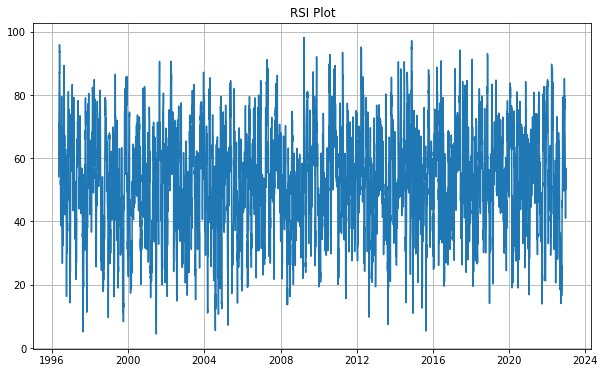

In [18]:
plot_rsi(df_KO)

In [19]:
def plot_K(df, k_col='K'):
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df[k_col])
    plt.title('K Value Plot')
    plt.grid(True)
    plt.show()

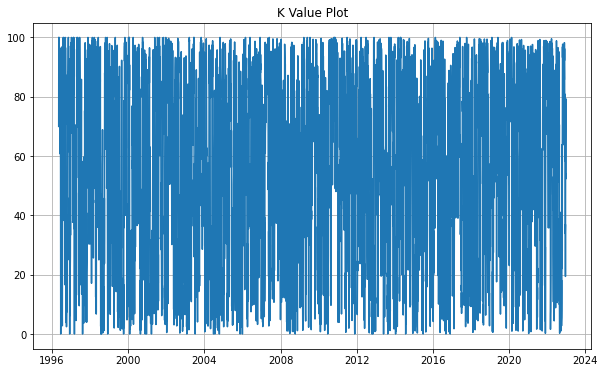

In [20]:
plot_K(df_KO)

Although the threshold values are frequently crossed, the RSI and K value plots oscillate rather uniformly in the long run, indicating that the market is experiencing regular periods of buying and selling pressure. The K value plot is denser than the RSI plot: this is a common feature as the K value tends to move more frequently. 

In [21]:
def plot_MACD_and_Signal(df, macd_col='MACD Line', signal_col='Signal Line'):
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df[macd_col], label='MACD Line', color='blue')
    plt.plot(df.index, df[signal_col], label='Signal Line', color='red')
    plt.title('MACD and Signal Line Plot')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    



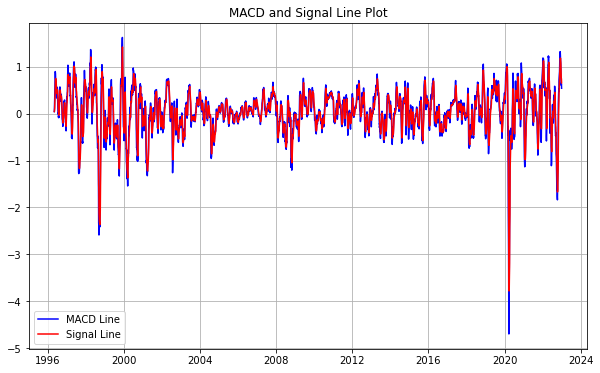

In [22]:
plot_MACD_and_Signal(df_KO)

We notice a few instances where the MACD line crosses above the Signal line indicating a bullish signal, most noticeably at the end of 1999 and during 2020. The last one can be interpreted as the result of the combination of a drop in the prices due to the COVID pandemic and the bullish trend of this particular stock. The most prominent instance where the MACD line crossed below the Signal line, indicating time to sell, was earlier in 2020 due to the COVID pandemic. 

In [23]:
def plot_ROC(df, roc_col='ROC'):
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df[roc_col])
    plt.title('Rate of Change Plot')
    plt.grid(True)
    plt.show()

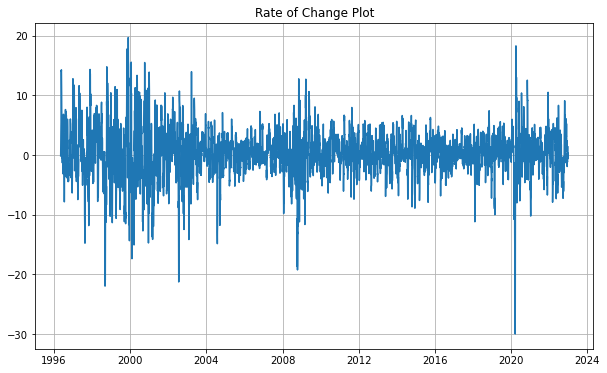

In [24]:
plot_ROC(df_KO)

The ROC plot shows a few points above +10 and below -10, indicating strong bullish and bearish signs. Perhaps the most prominant instance is the dramatic drop corresponding to the onset of the COVID pandemic, followed by a peak indicating time to buy a stock with an upward trend at a cheaper price.

In [25]:

def plot_OBV(df, obv_col='OBV'):
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df[obv_col])
    plt.title('On Balance Volume Plot')
    plt.grid(True)
    plt.show()

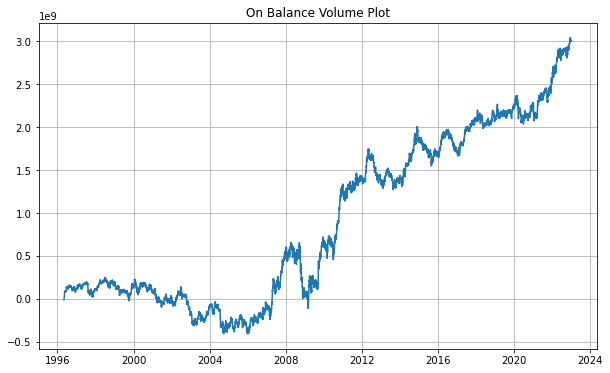

In [26]:
plot_OBV(df_KO)

This OBV distribution is very similar to the Close Price plot from the late 90s. There is a sign of bearish divergence from 1996 to 1998 as prices were rising but the OBV was rather stagnant. Indeed, a bearish trend followed from 1998 until around 2005, as we can check in the Close Price plot. 

In [27]:

def plot_PE(df, pe_col='P/E'):
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df[pe_col])
    plt.title('Price to Earnings Ratio Plot')
    plt.grid(True)
    plt.show()


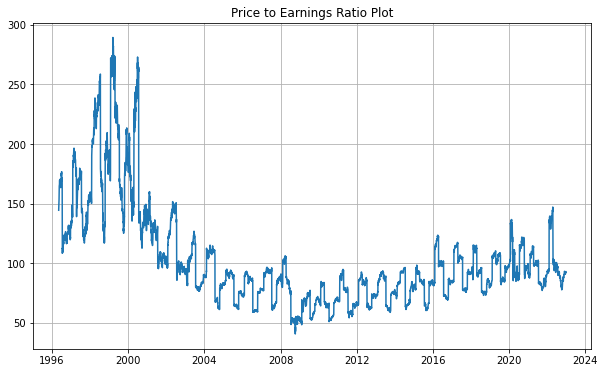

In [28]:
plot_PE(df_KO)

The P/E plot shows a strong seasonality component, inherited from the earnings per share. We observe extremely high values of P/E in the late 90s, indicating that the stock was overpriced. The bearish trend that followed the late 90s for this stock can be seen as a market correction of this overpricing. 

### Correlations

Since we have introduced new features, we may wonder how correlated they are to the original features. This could be useful in finding out patterns but also in identifying possible redundant features. Let's plot the correlation heatmap:

<AxesSubplot:>

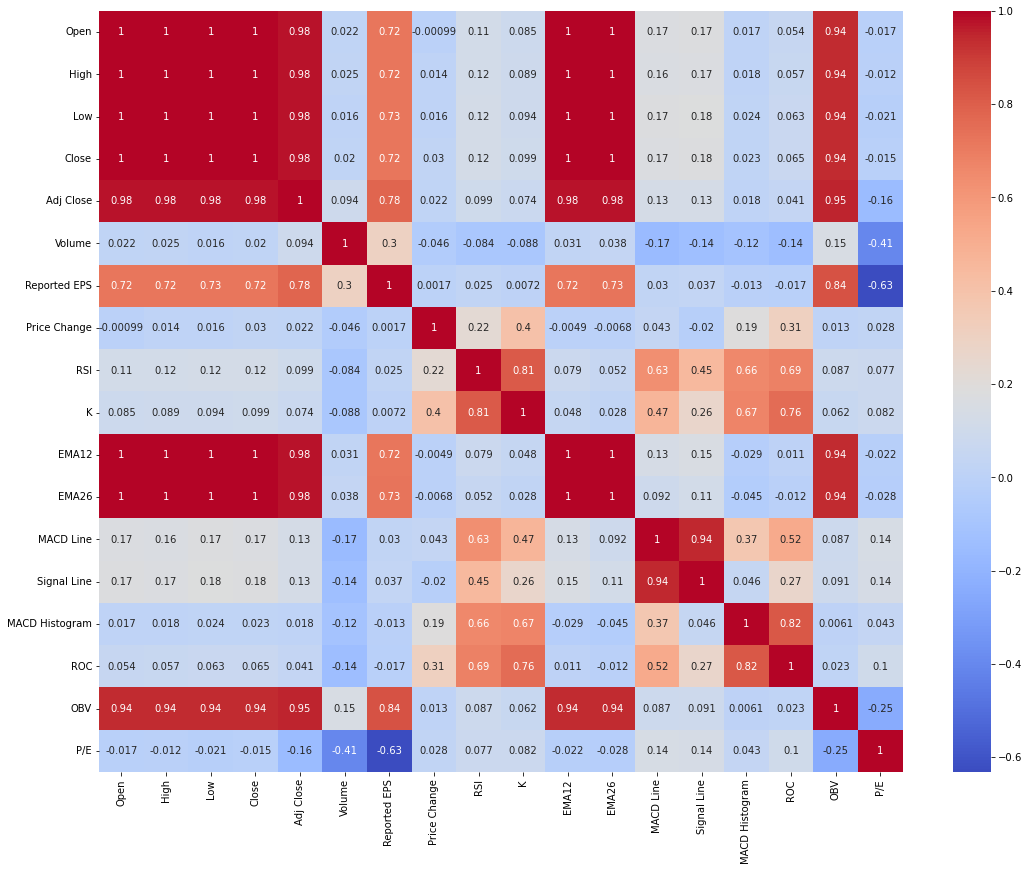

In [29]:
# Plot a correlation heatmap
correlation_matrix = df_KO.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

We observe a high correlation between EMA12, EMA 26 lines and prices, which was to be expected because of the definitions of the EMA12 and EMA26 indicators. The entries in all the corresponding columns have indeed very similar values. The OBV indicator is also highly correlated with prices, which again is not surprising as it is directly tied to the price through its calculation. Despite being highly correlated, all these features represent different information and we shall keep them in the sequel. 

### Train-test split

In time-series analysis, the order of the data points is important. Therefore, unlike traditional machine learning models where we perform a random train-test split, in time-series we often use a sequential split to preserve the temporal order of the observations. This is important because future data points are often dependent on past data points in time series data. So if we do a random split, we may be using future information to predict past events, which is not the right approach.

Instead, we can split the time series into training and test sets based on a certain threshold date or a proportion of data. In our case, we will implement our code so we can choose the percentage of data we will be using for testing. Based on this percentage, we will compute the index in our dataframe that will serve us to split the data into train and test sets.

In [30]:
# Create a function that to split our dataset into train and test sets. 

def train_test_split(df, test_size=0.02, target='Close'):
    '''
    Perform train-test split with respect to time series structure.

    Parameters:
    df: DataFrame, the input pandas DataFrame.
    test_size: float, the proportion of the dataset to include in the test split.
    target: str, the target variable to predict. Default is 'Close'.

    Returns:
    X_train, X_test, y_train, y_test : series, split datasets.
    '''

    # Ensure df is a pandas DataFrame
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Data should be a pandas DataFrame.")
    
    # Calculate the index at which to split the DataFrame into training and testing data
    split_index = int(len(df) * (1 - test_size))
    
    # Split the DataFrame into training and testing data
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]

    # Separate the features and the target variable in the training and testing sets
    X_train = train_data.drop([target], axis=1)
    y_train = train_data[target].to_frame() 
    X_test = test_data.drop([target], axis=1)
    y_test = test_data[target].to_frame() 
    
    return X_train, X_test, y_train, y_test

It is time now to perform a train/test split using the function just defined:

In [31]:
# Split our dataset into train and test sets. 
X_train, X_test, y_train, y_test = train_test_split(df_KO)

Our function `train_test_split` has been defined in a way that it returns the train and test split as datasets. Let's check this:

In [32]:
X_train

,Open,High,Low,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E
Date,,,,,,,,,,,,,,,,,
1996-05-06,19.937500,20.218750,19.750000,10.236874,7170400,0.14,0.281250,54.166667,70.000000,20.167723,20.122550,0.045173,0.045976,-0.000803,-0.154321,-10631600,144.419643
1996-05-07,20.218750,20.406250,20.156250,10.300159,6702800,0.14,0.125000,56.578947,83.333333,20.194804,20.138935,0.055869,0.047955,0.007914,1.244168,-3928800,145.312500
1996-05-08,20.343750,20.687500,20.062500,10.474213,8292800,0.14,0.343750,65.853659,100.000000,20.270603,20.179569,0.091034,0.056571,0.034463,1.846154,4364000,147.767857
1996-05-09,20.687500,20.937500,20.593750,10.474213,4820400,0.14,0.000000,71.052632,78.947368,20.334741,20.217194,0.117547,0.068766,0.048781,1.846154,4364000,147.767857
1996-05-10,20.718750,20.968750,20.718750,10.616608,4942800,0.14,0.281250,68.571429,100.000000,20.432281,20.272865,0.159416,0.086896,0.072520,3.389831,9306800,149.776786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,60.750000,62.290001,60.669998,59.126160,23064200,0.64,-0.070000,39.502762,18.965543,62.600185,63.125886,-0.525701,-0.299640,-0.226061,-3.218682,2802664700,95.843750
2022-06-14,60.730000,60.889999,58.660000,57.504799,24620000,0.64,-2.110001,20.757061,8.850929,62.081695,62.837302,-0.755607,-0.390833,-0.364773,-6.088473,2778044700,92.546874
2022-06-15,60.000000,60.639999,58.970001,57.931984,19684700,0.64,0.439999,24.358971,15.683207,61.710665,62.602687,-0.892022,-0.491071,-0.400951,-6.370628,2797729400,93.234372


In [33]:
y_test

,Close
Date,
2022-06-21,60.700001
2022-06-22,61.150002
2022-06-23,61.880001
2022-06-24,63.040001
2022-06-27,62.910000
...,...
2022-12-23,63.820000
2022-12-27,64.209999
2022-12-28,63.570000


### Rescaling numerical features

In the next notebook we will be training our machine learning models for stock price forecasting. We will be focusing on two models: a random forest and a Long-Short-Term-Memory (LSTM) network. Random forests are not sensitive to data rescaling, however neural networks are. So we will perform a rescaling of our dataframe here. 

We choose the RobustScaler scaler, as it is robust to outliers. For future convenience, we will save the scaler object of the target, as we will need to undo the scaling transformation in the next notebook after training our LSTM model. This is done with `joblib.dump`. 

In [34]:
# Initialize the scaler
scaler_features = RobustScaler()
scaler_target = RobustScaler()

# Fit the scaler on the training data
scaler_features.fit(X_train)
scaler_target.fit(y_train)

# Save the scaler object to a file
joblib.dump(scaler_target, 'robust_scaler.pkl')

# Transform the training and testing data
X_train_scaled_np = scaler_features.transform(X_train)
X_test_scaled_np = scaler_features.transform(X_test)

# Transform the training and testing data
y_train_scaled_np = scaler_target.transform(y_train)
y_test_scaled_np = scaler_target.transform(y_test)

The scaler returns a numpy object. We can convert back to a dataframe object using `pd.DataFrame`:

In [35]:
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)

In [36]:
X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=X_test.columns, index=X_test.index)

In [37]:
y_train_scaled = pd.DataFrame(y_train_scaled_np, columns=y_train.columns, index=X_train.index)

In [38]:
y_test_scaled = pd.DataFrame(y_test_scaled_np, columns=y_test.columns, index=X_test.index)

Let's check what the scaled dataframes look like:

In [39]:
X_train_scaled

,Open,High,Low,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E
Date,,,,,,,,,,,,,,,,,
1996-05-06,-0.689841,-0.693677,-0.678770,-0.422506,-0.655789,-0.888889,0.630819,0.070245,0.212880,-0.674981,-0.680908,-0.033041,-0.021565,-0.040518,-0.121317,-0.310841,1.387526
1996-05-07,-0.673631,-0.682887,-0.655356,-0.419209,-0.716175,-0.888889,0.267444,0.175655,0.461086,-0.673418,-0.679962,-0.011987,-0.017356,0.015311,0.230918,-0.306934,1.410663
1996-05-08,-0.666426,-0.666703,-0.660759,-0.410142,-0.510840,-0.888889,0.776169,0.580935,0.771343,-0.669041,-0.677618,0.057234,0.000971,0.185340,0.382539,-0.302101,1.474289
1996-05-09,-0.646614,-0.652316,-0.630142,-0.410142,-0.959272,-0.888889,-0.023257,0.808116,0.379439,-0.665338,-0.675447,0.109424,0.026912,0.277038,0.382539,-0.302101,1.474289
1996-05-10,-0.644813,-0.650518,-0.622938,-0.402724,-0.943465,-0.888889,0.630819,0.699694,0.771343,-0.659706,-0.672234,0.191841,0.065478,0.429069,0.771342,-0.299220,1.526347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,1.662464,1.727342,1.679562,2.124342,1.396766,0.962963,-0.186048,-0.570527,-0.737149,1.775061,1.800504,-1.156779,-0.756745,-1.483136,-0.893132,1.328875,0.128763
2022-06-14,1.661311,1.646778,1.563720,2.039879,1.597684,0.962963,-4.930275,-1.389663,-0.925437,1.745123,1.783852,-1.609337,-0.950728,-2.371494,-1.615941,1.314525,0.043330
2022-06-15,1.619236,1.632391,1.581587,2.062133,0.960331,0.962963,1.000004,-1.232269,-0.798251,1.723700,1.770314,-1.877864,-1.163950,-2.603186,-1.687006,1.325999,0.061145


In [40]:
X_test_scaled

,Open,High,Low,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E
Date,,,,,,,,,,,,,,,,,
2022-06-21,1.589842,1.646202,1.583892,2.114227,0.704669,0.962963,2.930257,-0.769740,-0.263972,1.680785,1.736679,-2.193513,-1.761705,-1.830460,-1.097885,1.347816,0.102849
2022-06-22,1.653818,1.679003,1.659391,2.136986,0.382085,0.962963,1.023265,-0.575868,-0.112215,1.682407,1.732961,-2.011394,-1.841590,-0.997427,-0.779300,1.356680,0.121070
2022-06-23,1.694164,1.705474,1.711836,2.173907,0.638277,0.962963,1.674431,-0.555514,0.133967,1.690264,1.732639,-1.732546,-1.845233,-0.079237,-0.049843,1.366699,0.150627
2022-06-24,1.740850,1.771652,1.762553,2.232577,0.761762,0.962963,2.674440,-0.095745,0.525161,1.707216,1.737299,-1.313570,-1.757595,1.020040,0.586083,1.377276,0.197595
2022-06-27,1.790994,1.784887,1.792522,2.226002,-0.013734,0.962963,-0.325587,-0.102666,0.604096,1.720406,1.741058,-0.992146,-1.618017,1.645553,0.562209,1.370199,0.192331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1.820965,1.818264,1.825373,2.318619,-0.747105,1.148148,1.093031,0.033830,0.080138,1.818461,1.778519,1.072814,1.515932,-1.071639,-0.141508,1.447711,0.041927
2022-12-27,1.845749,1.842433,1.854766,2.338629,-0.636379,1.148148,0.883726,0.188057,0.386468,1.826084,1.784781,1.119067,1.457091,-0.744000,0.004144,1.451978,0.056574
2022-12-28,1.876297,1.863149,1.842087,2.305792,-0.657209,1.148148,-1.511639,-0.101169,-0.116228,1.826849,1.787844,1.040665,1.393072,-0.806338,-0.247763,1.447805,0.032538


In [41]:
y_train_scaled

,Close
Date,
1996-05-06,-0.676602
1996-05-07,-0.669385
1996-05-08,-0.649538
1996-05-09,-0.649538
1996-05-10,-0.633300
...,...
2022-06-13,1.697604
2022-06-14,1.575779
2022-06-15,1.601184


In [42]:
y_test_scaled

,Close
Date,
2022-06-21,1.660653
2022-06-22,1.686634
2022-06-23,1.728782
2022-06-24,1.795756
2022-06-27,1.788251
...,...
2022-12-23,1.840791
2022-12-27,1.863308
2022-12-28,1.826357


We observe the presence of negative values for price in the `X_train_scaled` and `y_train_scaled` dataframes. This is fine for the purpose of training our models. We will just need to undo the rescaling transformation in the predicted values for a more straightforward interpretation.

### Including temporal categorial features

Including temporal features such as month and year in our dataset can potentially improve the performance of machine learning models, as these features can help capture any seasonal or yearly trends in the data. This can be especially useful for stock price prediction if there are patterns that repeat on a monthly or yearly basis. For instance, some stocks might have recurring patterns related to the time of year due to factors like seasonality in the company's business, fiscal reporting cycles, or broader market trends. By providing the month and year as additional input features, our model may be better able to learn these patterns and make more accurate predictions.

We shall include as additional categorical features the day, month and year of the observed stock price. 

In [43]:
# Add 'Day', 'Month' and 'Year' columns to X_train_scaled dataset
X_train_scaled['Day'] = X_train_scaled.index.day
X_train_scaled['Month'] = X_train_scaled.index.month
X_train_scaled['Year'] = X_train_scaled.index.year

In [44]:
# Add 'Day', 'Month' and 'Year' columns to X_test_scaled dataset
X_test_scaled['Day'] = X_test_scaled.index.day
X_test_scaled['Month'] = X_test_scaled.index.month
X_test_scaled['Year'] = X_test_scaled.index.year

One of the models we will be using, the Random Forest, is insensitive to rescaling. In this case, we find more intuitive to work with the original dataframe without rescaling. So we will also add the categorical features to the oriignal X_train and X_test features.

In [45]:
# Add 'Day', 'Month' and 'Year' columns to X_train dataset
X_train['Day'] = X_train.index.day
X_train['Month'] = X_train.index.month
X_train['Year'] = X_train.index.year

In [46]:
# Add 'Day', 'Month' and 'Year' columns to X_test dataset
X_test['Day'] = X_test.index.day
X_test['Month'] = X_test.index.month
X_test['Year'] = X_test.index.year

In [47]:
X_train

,Open,High,Low,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E,Day,Month,Year
Date,,,,,,,,,,,,,,,,,,,,
1996-05-06,19.937500,20.218750,19.750000,10.236874,7170400,0.14,0.281250,54.166667,70.000000,20.167723,20.122550,0.045173,0.045976,-0.000803,-0.154321,-10631600,144.419643,6,5,1996
1996-05-07,20.218750,20.406250,20.156250,10.300159,6702800,0.14,0.125000,56.578947,83.333333,20.194804,20.138935,0.055869,0.047955,0.007914,1.244168,-3928800,145.312500,7,5,1996
1996-05-08,20.343750,20.687500,20.062500,10.474213,8292800,0.14,0.343750,65.853659,100.000000,20.270603,20.179569,0.091034,0.056571,0.034463,1.846154,4364000,147.767857,8,5,1996
1996-05-09,20.687500,20.937500,20.593750,10.474213,4820400,0.14,0.000000,71.052632,78.947368,20.334741,20.217194,0.117547,0.068766,0.048781,1.846154,4364000,147.767857,9,5,1996
1996-05-10,20.718750,20.968750,20.718750,10.616608,4942800,0.14,0.281250,68.571429,100.000000,20.432281,20.272865,0.159416,0.086896,0.072520,3.389831,9306800,149.776786,10,5,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,60.750000,62.290001,60.669998,59.126160,23064200,0.64,-0.070000,39.502762,18.965543,62.600185,63.125886,-0.525701,-0.299640,-0.226061,-3.218682,2802664700,95.843750,13,6,2022
2022-06-14,60.730000,60.889999,58.660000,57.504799,24620000,0.64,-2.110001,20.757061,8.850929,62.081695,62.837302,-0.755607,-0.390833,-0.364773,-6.088473,2778044700,92.546874,14,6,2022
2022-06-15,60.000000,60.639999,58.970001,57.931984,19684700,0.64,0.439999,24.358971,15.683207,61.710665,62.602687,-0.892022,-0.491071,-0.400951,-6.370628,2797729400,93.234372,15,6,2022


Now we need to store this train/test split and its rescaled version in respective csv files for future use.

In [48]:
X_train_scaled.to_csv('X_train_KO_scaled.csv')
X_test_scaled.to_csv('X_test_KO_scaled.csv')

In [49]:
X_train.to_csv('X_train_KO.csv')
X_test.to_csv('X_test_KO.csv')

In [50]:
y_train_scaled.to_csv('y_train_KO_scaled.csv')
y_test_scaled.to_csv('y_test_KO_scaled.csv')

In [51]:
y_train.to_csv('y_train_KO.csv')
y_test.to_csv('y_test_KO.csv')

## Tesla stock

We shall now repeat the steps we followed previously but focusing this time on the TSLA stock. First we load our dataset:

In [52]:
# Read the csv file containing the data for the TSLA stock.
# index_col=0 tells pandas to use the first column as the index. 
# parse_dates=True tells pandas to interpret the index as a DateTimeIndex.
df_TSLA = pd.read_csv('TSLA.csv', parse_dates=True, index_col=0)

Let's compute the different financial indicators for the TSLA ticker:

In [53]:
rsi(df_TSLA)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI
Date,,,,,,,,,
2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,-0.0271,NaN,NaN
2010-08-06,1.340000,1.344000,1.301333,1.306000,1.306000,11128500,-0.0271,-0.057333,0.000000
2010-08-09,1.326667,1.332000,1.296667,1.306667,1.306667,12190500,-0.0271,0.000667,1.149959
2010-08-10,1.310000,1.310000,1.254667,1.268667,1.268667,19219500,-0.0271,-0.038000,0.694767
2010-08-11,1.246000,1.258667,1.190000,1.193333,1.193333,11964000,-0.0271,-0.075334,0.389284
...,...,...,...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,1.0500,-2.199997,8.967613
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,1.0500,-14.050003,7.743781
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,1.0500,3.610001,12.378847


In [54]:
k(df_TSLA)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K
Date,,,,,,,,,,
2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,-0.0271,NaN,NaN,NaN
2010-08-06,1.340000,1.344000,1.301333,1.306000,1.306000,11128500,-0.0271,-0.057333,0.000000,NaN
2010-08-09,1.326667,1.332000,1.296667,1.306667,1.306667,12190500,-0.0271,0.000667,1.149959,NaN
2010-08-10,1.310000,1.310000,1.254667,1.268667,1.268667,19219500,-0.0271,-0.038000,0.694767,NaN
2010-08-11,1.246000,1.258667,1.190000,1.193333,1.193333,11964000,-0.0271,-0.075334,0.389284,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,1.0500,-2.199997,8.967613,3.400934
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,1.0500,-14.050003,7.743781,0.461075
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,1.0500,3.610001,12.378847,6.019393


In [55]:
macd(df_TSLA)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram
Date,,,,,,,,,,,,,,,
2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,-0.0271,NaN,NaN,NaN,1.363333,1.363333,0.000000,0.000000,0.000000
2010-08-06,1.340000,1.344000,1.301333,1.306000,1.306000,11128500,-0.0271,-0.057333,0.000000,NaN,1.354513,1.359086,-0.004574,-0.000915,-0.003659
2010-08-09,1.326667,1.332000,1.296667,1.306667,1.306667,12190500,-0.0271,0.000667,1.149959,NaN,1.347152,1.355203,-0.008052,-0.002342,-0.005709
2010-08-10,1.310000,1.310000,1.254667,1.268667,1.268667,19219500,-0.0271,-0.038000,0.694767,NaN,1.335077,1.348793,-0.013716,-0.004617,-0.009099
2010-08-11,1.246000,1.258667,1.190000,1.193333,1.193333,11964000,-0.0271,-0.075334,0.389284,NaN,1.313270,1.337278,-0.024007,-0.008495,-0.015512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,1.0500,-2.199997,8.967613,3.400934,148.031122,165.275890,-17.244768,-13.664886,-3.579883
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,1.0500,-14.050003,7.743781,0.461075,142.041718,161.114713,-19.072995,-14.746507,-4.326487
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,1.0500,3.610001,12.378847,6.019393,137.529146,157.529179,-20.000032,-15.797212,-4.202820


In [56]:
roc(df_TSLA)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC
Date,,,,,,,,,,,,,,,,
2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,-0.0271,NaN,NaN,NaN,1.363333,1.363333,0.000000,0.000000,0.000000,NaN
2010-08-06,1.340000,1.344000,1.301333,1.306000,1.306000,11128500,-0.0271,-0.057333,0.000000,NaN,1.354513,1.359086,-0.004574,-0.000915,-0.003659,NaN
2010-08-09,1.326667,1.332000,1.296667,1.306667,1.306667,12190500,-0.0271,0.000667,1.149959,NaN,1.347152,1.355203,-0.008052,-0.002342,-0.005709,NaN
2010-08-10,1.310000,1.310000,1.254667,1.268667,1.268667,19219500,-0.0271,-0.038000,0.694767,NaN,1.335077,1.348793,-0.013716,-0.004617,-0.009099,NaN
2010-08-11,1.246000,1.258667,1.190000,1.193333,1.193333,11964000,-0.0271,-0.075334,0.389284,NaN,1.313270,1.337278,-0.024007,-0.008495,-0.015512,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,1.0500,-2.199997,8.967613,3.400934,148.031122,165.275890,-17.244768,-13.664886,-3.579883,-26.617807
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,1.0500,-14.050003,7.743781,0.461075,142.041718,161.114713,-19.072995,-14.746507,-4.326487,-32.214973
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,1.0500,3.610001,12.378847,6.019393,137.529146,157.529179,-20.000032,-15.797212,-4.202820,-28.118624


In [57]:
obv(df_TSLA)

/home/sergio/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV
Date,,,,,,,,,,,,,,,,,
2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,-0.0271,NaN,NaN,NaN,1.363333,1.363333,0.000000,0.000000,0.000000,NaN,0
2010-08-06,1.340000,1.344000,1.301333,1.306000,1.306000,11128500,-0.0271,-0.057333,0.000000,NaN,1.354513,1.359086,-0.004574,-0.000915,-0.003659,NaN,-11128500
2010-08-09,1.326667,1.332000,1.296667,1.306667,1.306667,12190500,-0.0271,0.000667,1.149959,NaN,1.347152,1.355203,-0.008052,-0.002342,-0.005709,NaN,1062000
2010-08-10,1.310000,1.310000,1.254667,1.268667,1.268667,19219500,-0.0271,-0.038000,0.694767,NaN,1.335077,1.348793,-0.013716,-0.004617,-0.009099,NaN,-18157500
2010-08-11,1.246000,1.258667,1.190000,1.193333,1.193333,11964000,-0.0271,-0.075334,0.389284,NaN,1.313270,1.337278,-0.024007,-0.008495,-0.015512,NaN,-30121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,1.0500,-2.199997,8.967613,3.400934,148.031122,165.275890,-17.244768,-13.664886,-3.579883,-26.617807,15901095400
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,1.0500,-14.050003,7.743781,0.461075,142.041718,161.114713,-19.072995,-14.746507,-4.326487,-32.214973,15692452000
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,1.0500,3.610001,12.378847,6.019393,137.529146,157.529179,-20.000032,-15.797212,-4.202820,-28.118624,15913522500


In [58]:
pe(df_TSLA)

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E
Date,,,,,,,,,,,,,,,,,,
2010-08-05,1.436000,1.436667,1.336667,1.363333,1.363333,11943000,-0.0271,NaN,NaN,NaN,1.363333,1.363333,0.000000,0.000000,0.000000,NaN,0,-50.307490
2010-08-06,1.340000,1.344000,1.301333,1.306000,1.306000,11128500,-0.0271,-0.057333,0.000000,NaN,1.354513,1.359086,-0.004574,-0.000915,-0.003659,NaN,-11128500,-48.191882
2010-08-09,1.326667,1.332000,1.296667,1.306667,1.306667,12190500,-0.0271,0.000667,1.149959,NaN,1.347152,1.355203,-0.008052,-0.002342,-0.005709,NaN,1062000,-48.216493
2010-08-10,1.310000,1.310000,1.254667,1.268667,1.268667,19219500,-0.0271,-0.038000,0.694767,NaN,1.335077,1.348793,-0.013716,-0.004617,-0.009099,NaN,-18157500,-46.814280
2010-08-11,1.246000,1.258667,1.190000,1.193333,1.193333,11964000,-0.0271,-0.075334,0.389284,NaN,1.313270,1.337278,-0.024007,-0.008495,-0.015512,NaN,-30121500,-44.034429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,1.0500,-2.199997,8.967613,3.400934,148.031122,165.275890,-17.244768,-13.664886,-3.579883,-26.617807,15901095400,117.285716
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,1.0500,-14.050003,7.743781,0.461075,142.041718,161.114713,-19.072995,-14.746507,-4.326487,-32.214973,15692452000,103.904760
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,1.0500,3.610001,12.378847,6.019393,137.529146,157.529179,-20.000032,-15.797212,-4.202820,-28.118624,15913522500,107.342856


We shall not drop the rows with NaN values.

In [59]:
# Drop rows with NaN values
df_TSLA = df_TSLA.dropna()

df_TSLA

,Open,High,Low,Close,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E
Date,,,,,,,,,,,,,,,,,,
2010-08-24,1.283333,1.314000,1.263333,1.280000,1.280000,10096500,-0.0271,-0.062000,41.184842,43.509628,1.281007,1.301034,-0.020027,-0.025088,0.005060,7.262595,-6639000,-47.232471
2010-08-25,1.277333,1.332000,1.237333,1.326667,1.326667,7549500,-0.0271,0.046667,46.469911,83.666960,1.288032,1.302933,-0.014901,-0.023050,0.008149,13.068233,910500,-48.954500
2010-08-26,1.326000,1.351333,1.306667,1.316667,1.316667,6507000,-0.0271,-0.010000,51.129968,78.666966,1.292437,1.303950,-0.011513,-0.020743,0.009230,7.805728,-5596500,-48.585497
2010-08-27,1.316667,1.324667,1.300000,1.313333,1.313333,5694000,-0.0271,-0.003334,50.702179,77.000004,1.295652,1.304645,-0.008994,-0.018393,0.009400,4.898807,-11290500,-48.462474
2010-08-30,1.313333,1.346000,1.307333,1.324667,1.324667,10992000,-0.0271,0.011334,56.249947,82.666973,1.300116,1.306129,-0.006013,-0.015917,0.009904,3.759788,-298500,-48.880700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,126.370003,128.619995,121.019997,123.150002,123.150002,166989700,1.0500,-2.199997,8.967613,3.400934,148.031122,165.275890,-17.244768,-13.664886,-3.579883,-26.617807,15901095400,117.285716
2022-12-27,117.500000,119.669998,108.760002,109.099998,109.099998,208643400,1.0500,-14.050003,7.743781,0.461075,142.041718,161.114713,-19.072995,-14.746507,-4.326487,-32.214973,15692452000,103.904760
2022-12-28,110.349998,116.269997,108.239998,112.709999,112.709999,221070500,1.0500,3.610001,12.378847,6.019393,137.529146,157.529179,-20.000032,-15.797212,-4.202820,-28.118624,15913522500,107.342856


### Plots

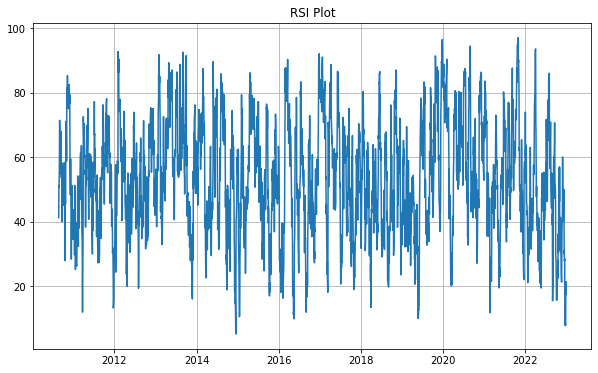

In [60]:
plot_rsi(df_TSLA)

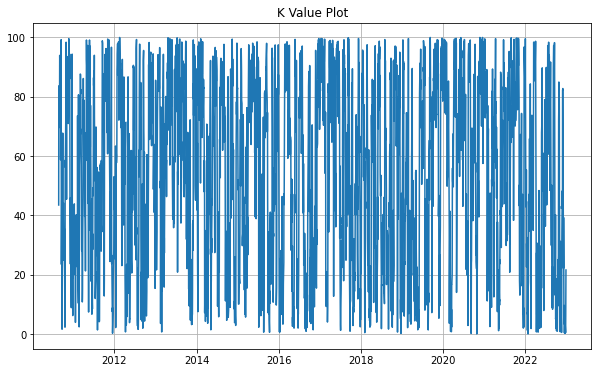

In [61]:
plot_K(df_TSLA)

In this case the RSI and K value plots seems to cross more frequently their respective 'overbought' threshold. This is consistent with the history of TESLA of being frequently overbought and overpriced. 

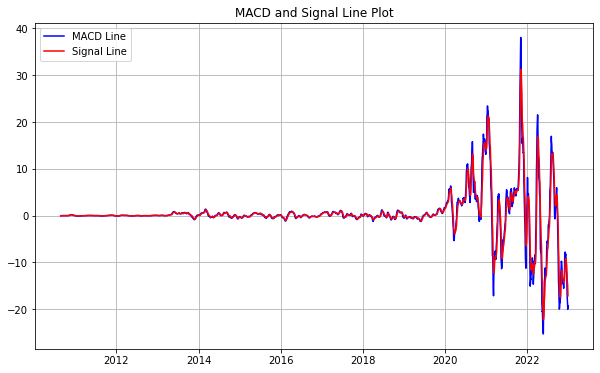

In [62]:
plot_MACD_and_Signal(df_TSLA)

The MACD plot indicates an almost alternating history of bullish and bearish signals since the company starts experiencing an exponential growth in 2020, which is consistent with the stock's high volatility. 

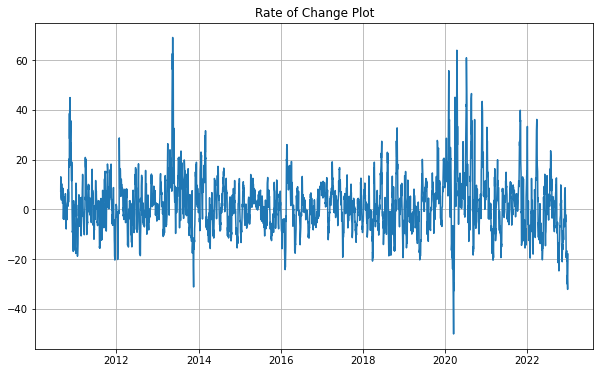

In [63]:
plot_ROC(df_TSLA)

The ROC plot generally oscillates between +20 and -20, which are already high values indicating respectively bullish and bearish signs. There are quite a few points with more extreme values, such as the one above +60 in 2013, which we can check in the Close Price plot that was followed by a trend of slight growth and can be related to the company reporting higher-than-expected demand for its Model S electric sedan. Or the very negative value below -40 in 2020 related to the onset of the COVID pandemic. We also observe that from 2020 the peaks are more frequent, which can be related to the cascade of news about the company that resulted in the stock's high volatility.

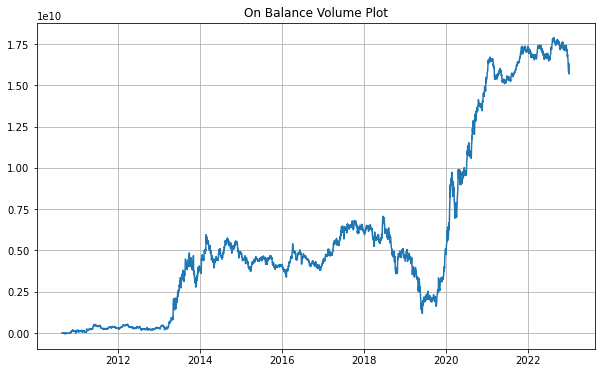

In [64]:
plot_OBV(df_TSLA)

We observe a period between 2018 and late 2019 where the OBV plot fell down while the Close Price remained ŕather constant. This suggests that volume on down days is outweighing volume on up days, and could be a sign that selling pressure is increasing, which could precede a drop in the price. In this case, this scenario could have resulted from the frequent negative EPS reported by the company over that period, which could have influenced the investors' behavior. Contrarily to the expectations, the company started a period of exponential growth just in 2020. 

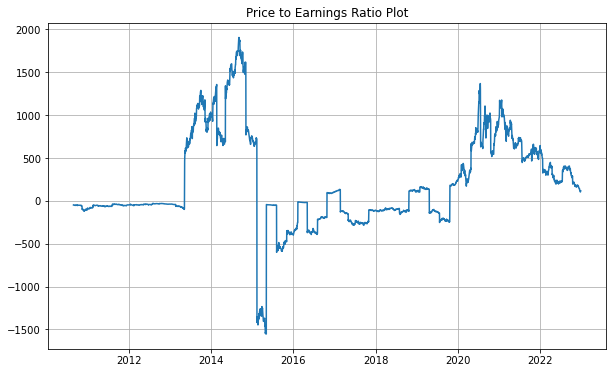

In [65]:
plot_PE(df_TSLA)

### Correlations

Let's have a look at the correlation heatmap of the columns in `df_TSLA`:

<AxesSubplot:>

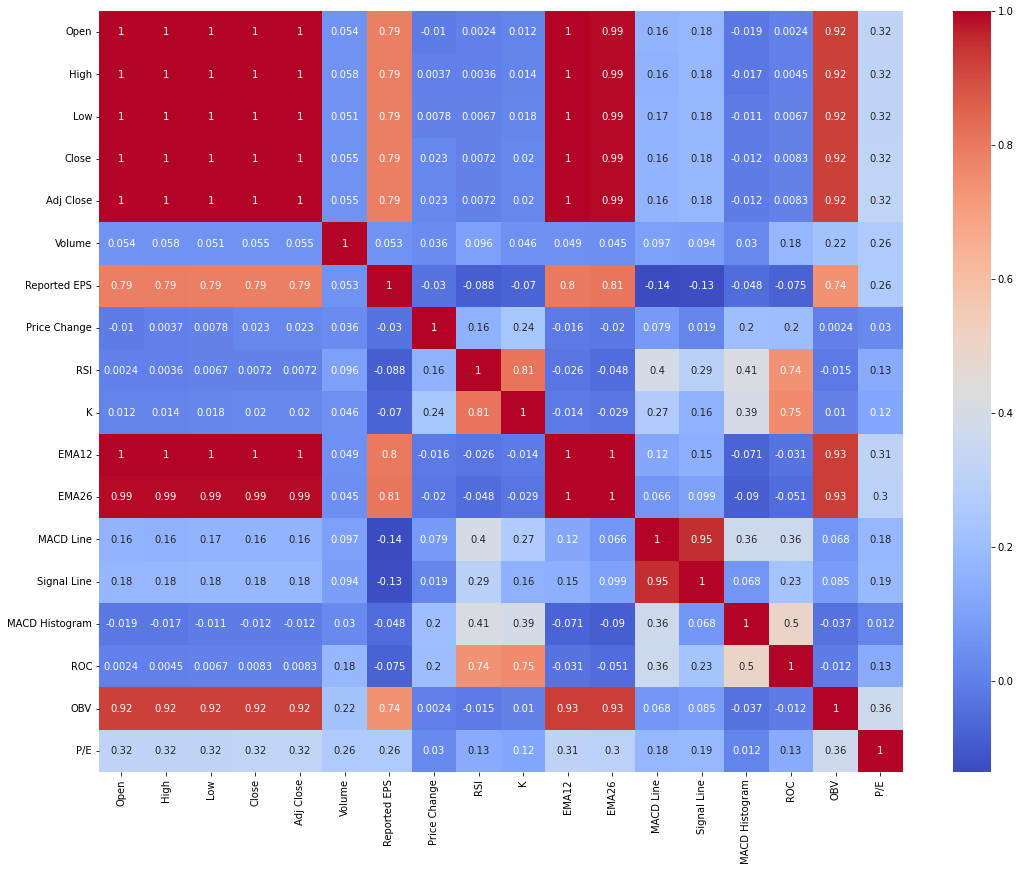

In [66]:
# Plot a correlation heatmap of all columns in 'df_TSLA'
correlation_matrix = df_TSLA.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

We observe a similar pattern to the one described for the KO stock: a strong correlation between prices, EMA12 and EMA26 and OBV.

### Train-test split

We can use the function `train_test_split` defined above to perform a train-test split of the TSLA dataset.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df_TSLA)

### Rescaling

We follow the same steps for the rescaling of numerical features as above:

In [68]:
# Initialize the scaler
scaler_features = RobustScaler()
scaler_target = RobustScaler()

# Fit the scaler on the training data
scaler_features.fit(X_train)
scaler_target.fit(y_train)

# Save the scaler object to a file
joblib.dump(scaler_target, 'robust_scaler2.pkl')

# Transform the training and testing data
X_train_scaled_np = scaler_features.transform(X_train)
X_test_scaled_np = scaler_features.transform(X_test)

# Transform the training and testing data
y_train_scaled_np = scaler_target.transform(y_train)
y_test_scaled_np = scaler_target.transform(y_test)

We can transform the numpy objects back to DataFrame:

In [69]:
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns, index=X_train.index)

In [70]:
X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=X_test.columns, index=X_test.index)

In [71]:
y_train_scaled = pd.DataFrame(y_train_scaled_np, columns=y_train.columns, index=X_train.index)

In [72]:
y_test_scaled = pd.DataFrame(y_test_scaled_np, columns=y_test.columns, index=X_test.index)

### Including temporal categorial features

We include the temporal categorical features `Day`, `Month` and `Year` to our dataframes:

In [73]:
# Add 'Day', 'Month' and 'Year' columns to X_train_scaled dataset
X_train_scaled['Day'] = X_train_scaled.index.day
X_train_scaled['Month'] = X_train_scaled.index.month
X_train_scaled['Year'] = X_train_scaled.index.year

In [74]:
# Add 'Day', 'Month' and 'Year' columns to X_test_scaled dataset
X_test_scaled['Day'] = X_test_scaled.index.day
X_test_scaled['Month'] = X_test_scaled.index.month
X_test_scaled['Year'] = X_test_scaled.index.year

Also for the unscaled ones:

In [75]:
# Add 'Day', 'Month' and 'Year' columns to X_train dataset
X_train['Day'] = X_train.index.day
X_train['Month'] = X_train.index.month
X_train['Year'] = X_train.index.year

In [76]:
# Add 'Day', 'Month' and 'Year' columns to X_test dataset
X_test['Day'] = X_test.index.day
X_test['Month'] = X_test.index.month
X_test['Year'] = X_test.index.year

We finish by saving our train-test split into csv files:

In [77]:
X_train_scaled.to_csv('X_train_TSLA_scaled.csv')
X_test_scaled.to_csv('X_test_TSLA_scaled.csv')

In [78]:
X_train.to_csv('X_train_TSLA.csv')
X_test.to_csv('X_test_TSLA.csv')

In [79]:
y_train_scaled.to_csv('y_train_TSLA_scaled.csv')
y_test_scaled.to_csv('y_test_TSLA_scaled.csv')

In [80]:
y_train.to_csv('y_train_TSLA.csv')
y_test.to_csv('y_test_TSLA.csv')